In [512]:
# Import all necessary packages:

!pip install pynamics
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint,KinematicConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [513]:
system = System()
pynamics.set_system(__name__,system)

In [514]:
lA = Constant(0.075*0.67,'lA',system)
lB = Constant(0.075*0.33,'lB',system)

mA = Constant(0.006*0.67,'mA',system)  # Edit these mass values to approximate the mass of the material used. mA should be 2/3 of the mass of the end effector.
mB = Constant(0.006*0.33,'mB',system)  # Edit these mass values to approximate the mass of the material used. mB should be 1/3 of the mass of the end effector.

g = Constant(9.81,'g',system)
b = Constant(1e-1,'b',system)
k = Constant(2.2e-1,'k',system)  # N*m/rad    # Run the code with the appropriate masses applied. Analyze the value of the deflection (Final Value of End_Y Below).
  # Then edit the value of k incrementally until the desired deflection is achieved (I.e. If deflection needs to be larger, decrease k. If deflection needs to be smaller, increase k.)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)

Ixx_A = Constant(2/3*1.066667*10**-6,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(2/3*1.041667*10**-6,'Izz_A',system)
Ixx_B = Constant(1/3*1.066667*10**-6,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1/3*1.041667*10**-6,'Izz_B',system)

torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)
qA = Constant(0,'qA',system)

m_weight = Constant(0.32,'m_weight',system)   # Edit this weight to change the weight applied to the end effector

In [515]:

qB,qB_d,qB_dd = Differentiable('qB',system)

In [516]:
initialvalues = {}
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180

In [517]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [518]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)

In [519]:
system.set_newtonian(N)

In [520]:
A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)

In [521]:
pNA = 0*N.x
pAB = pNA + lA*A.x
pBTip = pAB + lB*B.x

In [522]:
pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x

In [523]:
points = [pNA,pAB,pBTip]

p = numpy.array(points)

In [524]:
l = len(p)

state1 = initialvalues


px = []
for i in range(0,l):
    q = p[i]
    x = q.dot(N.x)
    px.append(x)

px1 = [item.subs(state1) for item in px]
px1 = [item.subs(system.constant_values) for item in px1]
print('px1: ')
print(px1)

py = []
for i in range(0,l):
    q = p[i]
    y = q.dot(N.y)
    py.append(y)

py1 = [item.subs(state1) for item in py]
py1 = [item.subs(system.constant_values) for item in py1]
print('py1: ')
print(py1)

pz = []
for i in range(0,l):
    q = p[i]
    z = q.dot(N.z)
    pz.append(z)

pz1 = [item.subs(state1) for item in pz]
pz1 = [item.subs(system.constant_values) for item in pz1]
print('pz1: ')
print(pz1)

px1: 
[0, 0.0502500000000000, 0.0750000000000000]
py1: 
[0, 0, 0]
pz1: 
[0, 0, 0]


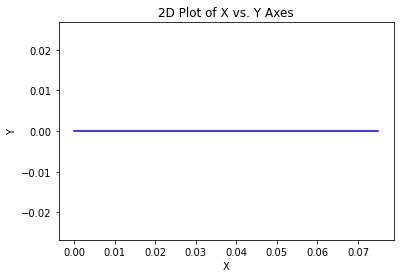

In [525]:
# 2D Plot (X vs. Y Axes)

plt.plot(px1[0:4],py1[0:4],'b')
plt.plot(px1[4:l],py1[4:l],'b')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot of X vs. Y Axes');

In [526]:
#wNA = N.get_w_to(A)
wAB = A.get_w_to(B)

In [527]:
vBTip = pBTip.time_derivative(N,system)
Particle1 = Particle(pBTip,m_weight,'Particle1',system)

In [528]:
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)

In [529]:
#ystem.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)

In [530]:
#system.add_spring_force1(k,(qA-preload1)*N.z,wNA)
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)

(<pynamics.force.Force at 0x7f628053f350>,
 <pynamics.spring.Spring at 0x7f628001ba90>)

In [531]:
system.addforcegravity(-g*N.y)
#system.addforce(-g*m_weight*N.y,vBTip)


In [532]:
use_constraints = True
#if use_constraints:
#    eq = []
#    eq.append(pBTip)
#    eq_d=[item.time_derivative() for item in eq]
#    eq_dd=[item.time_derivative() for item in eq_d]
#    eq_dd_scalar = []
#    eq_dd_scalar.append(eq_dd[0].dot(N.x))
#    constraint = AccelerationConstraint(eq_dd_scalar)
#    system.add_constraint(constraint)

In [533]:
f,ma = system.getdynamics()

2022-04-27 07:34:45,196 - pynamics.system - INFO - getting dynamic equations


In [534]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-04-27 07:34:45,288 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-27 07:34:45,294 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-27 07:34:45,315 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-27 07:34:45,318 - pynamics.system - INFO - calculating function for lambdas


In [535]:
tol = 1e-7

In [536]:
# Time:

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [537]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-04-27 07:34:45,348 - pynamics.integration - INFO - beginning integration
2022-04-27 07:34:45,351 - pynamics.system - INFO - integration at time 0000.00
2022-04-27 07:34:45,398 - pynamics.integration - INFO - finished integration


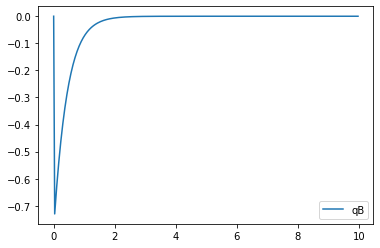

In [538]:
plt.figure()
artists = plt.plot(t,states[:,1])
plt.legend(artists,['qB'])

2022-04-27 07:34:45,632 - pynamics.output - INFO - calculating outputs
2022-04-27 07:34:45,643 - pynamics.output - INFO - done calculating outputs


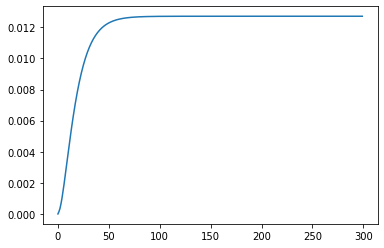

In [539]:
KE = system.get_KE()
PE = system.getPEGravity(pBTip) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

In [540]:
#if use_constraints:
#    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
#    plt.figure()
#    plt.plot(t, lambda2)

2022-04-27 07:34:45,886 - pynamics.output - INFO - calculating outputs
2022-04-27 07:34:45,906 - pynamics.output - INFO - done calculating outputs


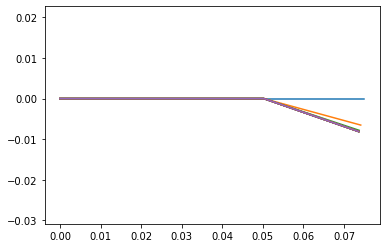

In [541]:
points = [pNA,pAB,pBTip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

In [542]:
End_Y = y[:,2]
End_Y = End_Y[:,1]
End_Y[-1]  # The final value in this array represents the final end effector deflection in the y-direction. Use this to adjust k and reach the desired deflection.

-0.008127819790890526

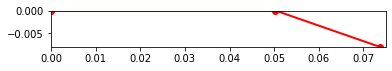

In [543]:
# Motion Animation:

points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())